<a href="https://colab.research.google.com/github/PorandlaThrishank/Object-Detection-on-PASCAL-VOC-2012/blob/main/ObjectDetection_TF_VOC2012_EfficientDet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm.auto import tqdm
import random
import tensorflow as tf
import keras_cv


In [8]:
import pathlib

base_dir = pathlib.Path("/content/drive/MyDrive/Coincent Internship Project/VOC2012")
img_dir = base_dir / "JPEGImages"
ann_dir = base_dir / "Annotations"
sets_dir = base_dir / "ImageSets" / "Main"

import os
print("Images:", len(os.listdir(img_dir)))
print("Annotations:", len(os.listdir(ann_dir)))

assert img_dir.exists(), "Image directory missing"
assert ann_dir.exists(), "Annotations directory missing"

Images: 17125
Annotations: 17125


In [ ]:
split_file = sets_dir / "trainval.txt"
if not split_file.exists():
    # Fallback: build a split
    all_ids = [p.stem for p in img_dir.glob("*.jpg")]
    random.shuffle(all_ids)
    split = int(0.8 * len(all_ids))
    train_ids, val_ids = all_ids[:split], all_ids[split:]
else:
    with open(split_file) as f:
        all_ids = [line.strip() for line in f if line.strip()]
    random.shuffle(all_ids)
    split = int(0.8 * len(all_ids))
    train_ids, val_ids = all_ids[:split], all_ids[split:]

print("Train images:", len(train_ids), "Val images:", len(val_ids))


In [ ]:
# VOC classes
VOC_CLASSES = [
    "aeroplane","bicycle","bird","boat","bottle",
    "bus","car","cat","chair","cow",
    "diningtable","dog","horse","motorbike","person",
    "pottedplant","sheep","sofa","train","tvmonitor"
]
cls_to_id = {c:i for i,c in enumerate(VOC_CLASSES)}

def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    size = root.find("size")
    w = int(size.find("width").text)
    h = int(size.find("height").text)
    objs = []
    for obj in root.findall("object"):
        name = obj.find("name").text
        difficult = int(obj.find("difficult").text) if obj.find("difficult") is not None else 0
        bnd = obj.find("bndbox")
        xmin = int(float(bnd.find("xmin").text))
        ymin = int(float(bnd.find("ymin").text))
        xmax = int(float(bnd.find("xmax").text))
        ymax = int(float(bnd.find("ymax").text))
        objs.append({
            "label": name,
            "difficult": difficult,
            "bbox": [xmin, ymin, xmax, ymax],
        })
    return w, h, objs

def build_records(id_list):
    recs = []
    for img_id in tqdm(id_list, desc="Parsing"):
        img_path = img_dir / f"{img_id}.jpg"
        xml_path = ann_dir / f"{img_id}.xml"
        if not xml_path.exists() or not img_path.exists():
            continue
        w,h,objs = parse_voc_xml(xml_path)
        for o in objs:
            if o["label"] not in cls_to_id:
                continue
            recs.append({
                "image_id": img_id,
                "image_path": str(img_path),
                "width": w, "height": h,
                "xmin": o["bbox"][0], "ymin": o["bbox"][1],
                "xmax": o["bbox"][2], "ymax": o["bbox"][3],
                "label": o["label"],
                "label_id": cls_to_id[o["label"]],
                "difficult": o["difficult"]
            })
    return pd.DataFrame(recs)

df_train = build_records(train_ids)
df_val   = build_records(val_ids)
print(df_train.head())
print("Train boxes:", len(df_train), "Val boxes:", len(df_val))

In [12]:
IMG_SIZE = 500

def preprocess(row):
    img = tf.io.read_file(row["image_path"])
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

    x_min, y_min, x_max, y_max = [row[k] for k in ["xmin","ymin","xmax","ymax"]]
    boxes = tf.convert_to_tensor([[x_min/row["width"], y_min/row["height"],
                                   x_max/row["width"], y_max/row["height"]]], dtype=tf.float32)
    classes = tf.convert_to_tensor([row["label_id"]], dtype=tf.int32)

    return {"images": img,
            "bounding_boxes": {"boxes": boxes, "classes": classes}}

def make_tf_dataset(df, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(dict(df))
    if shuffle: ds = ds.shuffle(512)
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.padded_batch(8)
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = make_tf_dataset(df_train)
val_ds   = make_tf_dataset(df_val, shuffle=False)


In [18]:
def make_tf_dataset(df, shuffle=True, batch_size=8):
    def gen():
        for _, row in df.iterrows():
            img = tf.io.read_file(row["image_path"])
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.convert_image_dtype(img, tf.float32)  # normalize [0,1]

            # normalize bbox to [0,1] relative to width & height
            xmin = row["xmin"] / row["width"]
            ymin = row["ymin"] / row["height"]
            xmax = row["xmax"] / row["width"]
            ymax = row["ymax"] / row["height"]

            yield {
                "images": img,
                "bounding_boxes": {
                    "boxes": tf.constant([[xmin, ymin, xmax, ymax]], dtype=tf.float32),
                    "classes": tf.constant([row["label_id"]], dtype=tf.int32),
                },
            }

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature={
            "images": tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),
            "bounding_boxes": {
                "boxes": tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                "classes": tf.TensorSpec(shape=(None,), dtype=tf.int32),
            },
        },
    )
    if shuffle:
        ds = ds.shuffle(512)
    return ds.padded_batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds = make_tf_dataset(df_train)
val_ds   = make_tf_dataset(df_val, shuffle=False)


In [19]:
batch = next(iter(train_ds))

images = batch["images"]
boxes = batch["bounding_boxes"]["boxes"]
classes = batch["bounding_boxes"]["classes"]

print("Batch image shape:", images.shape)
print("Batch boxes shape:", boxes.shape)
print("Batch classes shape:", classes.shape)


Batch image shape: (8, 500, 500, 3)
Batch boxes shape: (8, 1, 4)
Batch classes shape: (8, 1)


images: (8, 512, 512, 3)
boxes: (8, 7, 4)
classes: (8, 7)


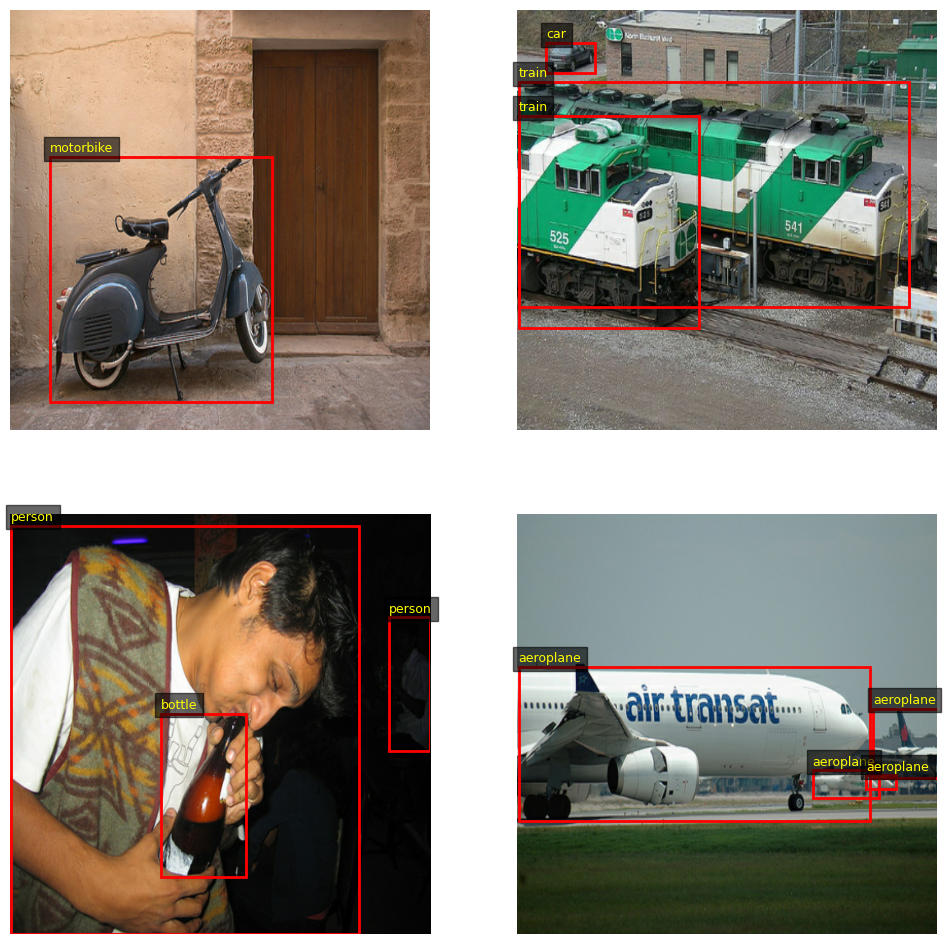

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

IMG_SIZE = 512
BATCH_SIZE = 8

def grouped_records(df):
    groups = {}
    for _, row in df.iterrows():
        img_id = row["image_id"]
        groups.setdefault(img_id, []).append(row)
    records = []
    for img_id, rows in groups.items():
        first = rows[0]
        img_path = first["image_path"]
        orig_w = float(first["width"])
        orig_h = float(first["height"])
        boxes = []
        classes = []
        for r in rows:
            boxes.append([r["xmin"], r["ymin"], r["xmax"], r["ymax"]])
            classes.append(int(r["label_id"]))
        boxes = np.array(boxes, dtype=np.float32)   # (N,4)
        classes = np.array(classes, dtype=np.int32) # (N,)
        records.append({
            "image_path": img_path,
            "orig_w": orig_w,
            "orig_h": orig_h,
            "boxes": boxes,
            "classes": classes
        })
    return records

train_records = grouped_records(df_train)
val_records   = grouped_records(df_val)

def generator(records):
    for rec in records:

        img = tf.io.read_file(rec["image_path"])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        boxes = rec["boxes"].astype(np.float32)
        boxes[:, 0] /= rec["orig_w"]   # xmin / w
        boxes[:, 2] /= rec["orig_w"]   # xmax / w
        boxes[:, 1] /= rec["orig_h"]   # ymin / h
        boxes[:, 3] /= rec["orig_h"]   # ymax / h

        # resize image to fixed size (no padding) - normalized boxes still valid
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

        yield {
            "images": img,                                  # (IMG_SIZE,IMG_SIZE,3) float32
            "bounding_boxes": {
                "boxes": tf.convert_to_tensor(boxes, dtype=tf.float32),   # (N,4)
                "classes": tf.convert_to_tensor(rec["classes"], dtype=tf.int32), # (N,)
            }
        }

# Build tf.data.Dataset
output_signature = {
    "images": tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
    "bounding_boxes": {
        "boxes": tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
        "classes": tf.TensorSpec(shape=(None,), dtype=tf.int32),
    }
}

train_ds = tf.data.Dataset.from_generator(lambda: generator(train_records), output_signature=output_signature)
val_ds   = tf.data.Dataset.from_generator(lambda: generator(val_records), output_signature=output_signature)

# shuffle, padded batch (images are already fixed-size, only boxes/classes need padding)
padding_values = {
    "images": tf.constant(0.0, dtype=tf.float32),
    "bounding_boxes": {
        "boxes": tf.constant(0.0, dtype=tf.float32),
        "classes": tf.constant(-1, dtype=tf.int32),
    }
}

train_ds = train_ds.shuffle(512).padded_batch(BATCH_SIZE, padding_values=padding_values).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.padded_batch(BATCH_SIZE, padding_values=padding_values).prefetch(tf.data.AUTOTUNE)

batch = next(iter(train_ds))
print("images:", batch["images"].shape)                          # (B, IMG_SIZE, IMG_SIZE, 3)
print("boxes:", batch["bounding_boxes"]["boxes"].shape)          # (B, max_objects, 4)
print("classes:", batch["bounding_boxes"]["classes"].shape)      # (B, max_objects)


def show_batch(batch, VOC_CLASSES, n=4):
    imgs = batch["images"].numpy()
    boxes = batch["bounding_boxes"]["boxes"].numpy()
    classes = batch["bounding_boxes"]["classes"].numpy()
    plt.figure(figsize=(12,12))
    for i in range(min(n, imgs.shape[0])):
        img = imgs[i]
        plt.subplot(2,2,i+1)
        plt.imshow(img)
        h, w = IMG_SIZE, IMG_SIZE
        for j in range(boxes.shape[1]):
            cls = int(classes[i,j])
            if cls < 0:
                continue
            xmin, ymin, xmax, ymax = boxes[i,j]
            # scaled coords
            x1, y1, x2, y2 = xmin * w, ymin * h, xmax * w, ymax * h
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x1, y1-6, VOC_CLASSES[cls], color='yellow', fontsize=9, bbox=dict(facecolor='black', alpha=0.6))
        plt.axis("off")
    plt.show()

import matplotlib.patches as patches
show_batch(batch, VOC_CLASSES)
